In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Markdown, SVG, HTML
import pandas as pd
import altair as alt
import re
import pickle
from utils import seconds_to_ms, ms_to_seconds
from benchmark_result import get_benchmark_results,get_time_n_tasks_source, get_no_delay_source, BenchmarkType, get_broad_cast_source, get_echo_many_arguments_source
from benchmarks.utils import echo
from benchmarks.overhead_latency import echo_many_arguments
InteractiveShell.ast_node_interactivity = "all"

In [2]:
benchmark_results = get_benchmark_results()
##from benchmark_result import BenchmarkResult, Result 
##with open('saved_results.pkl', 'rb') as saved_results:
##    benchmark_results = pickle.load(saved_results)

## ipyparallel benchmark results ##

### time_n_tasks ###
The first benchmark comes from benchmarking the runtime of sending
n tasks to m engines. Where the each task is just the echo function. 

In [3]:
??echo

Signature: echo(delay=0)
Docstring: <no docstring>
Source:   
def echo(delay=0):
    def inner_echo(x):
        import time

        if delay:
            time.sleep(delay)
        return x

    return inner_echo
File:      ~/ipyparallel_master_project/benchmarks/utils.py
Type:      function


### With a delay of 0.0s. :

#### 16 cores:

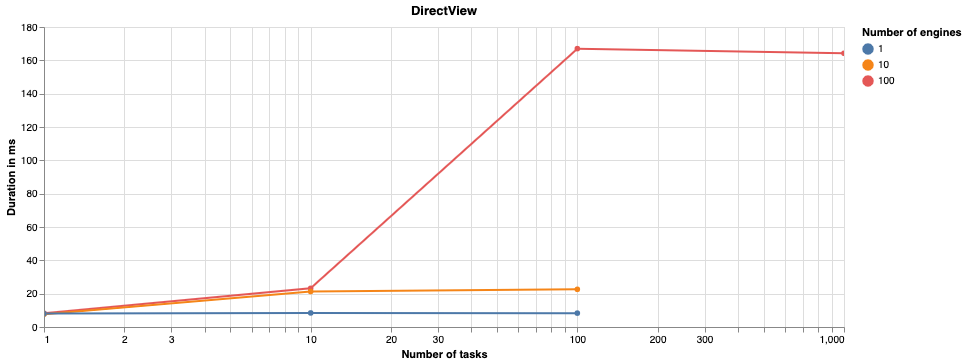

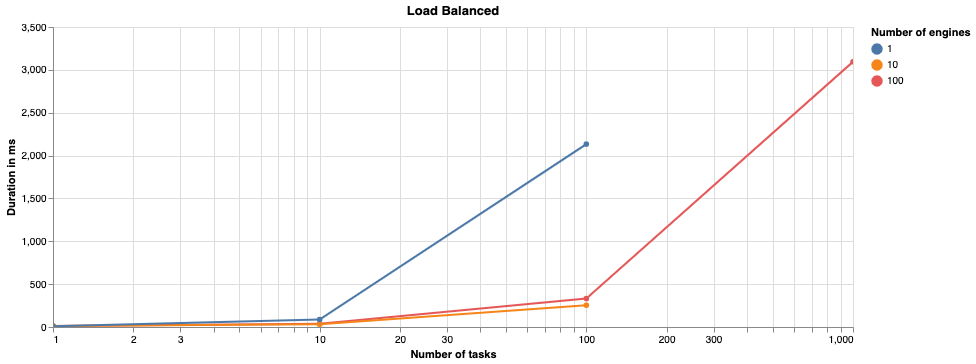

#### 64 cores:

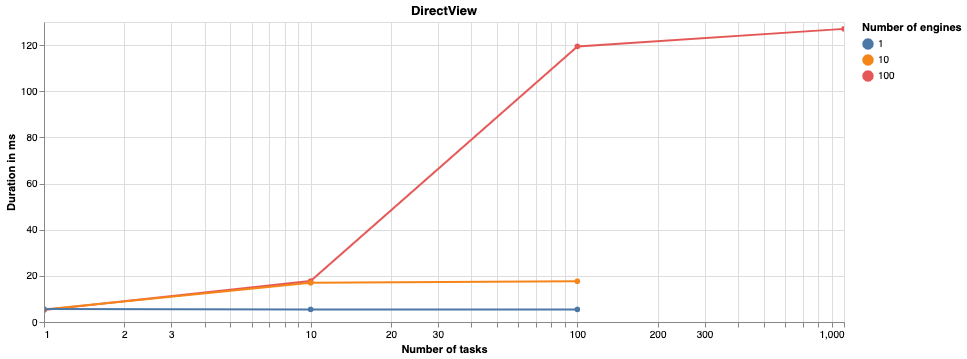

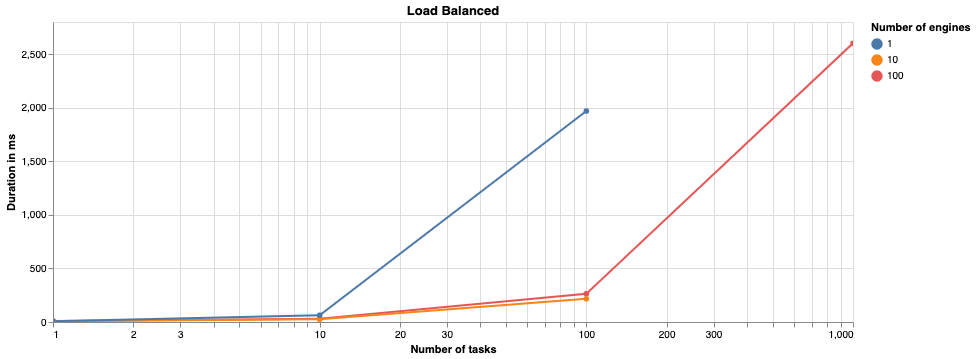

### With a delay of 0.1s. :

#### 16 cores:

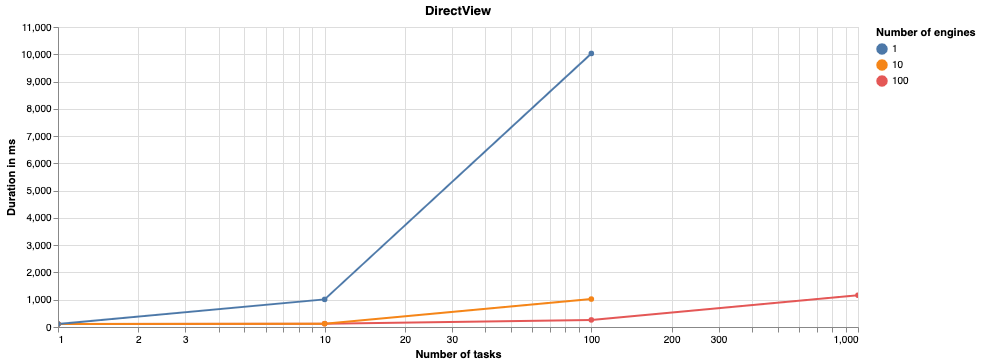

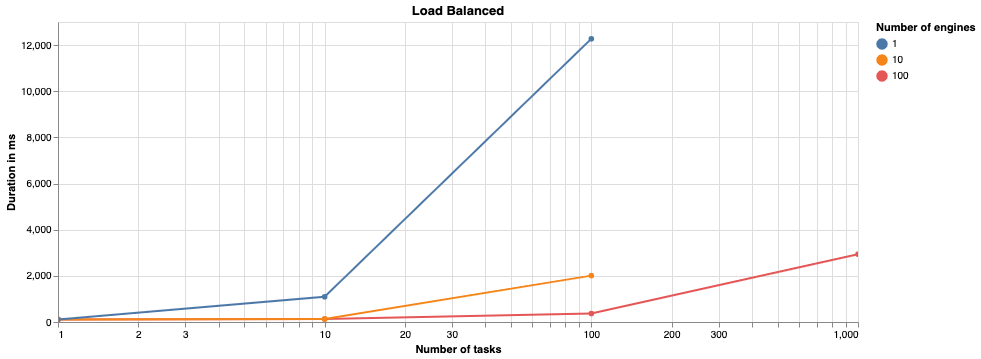

#### 64 cores:

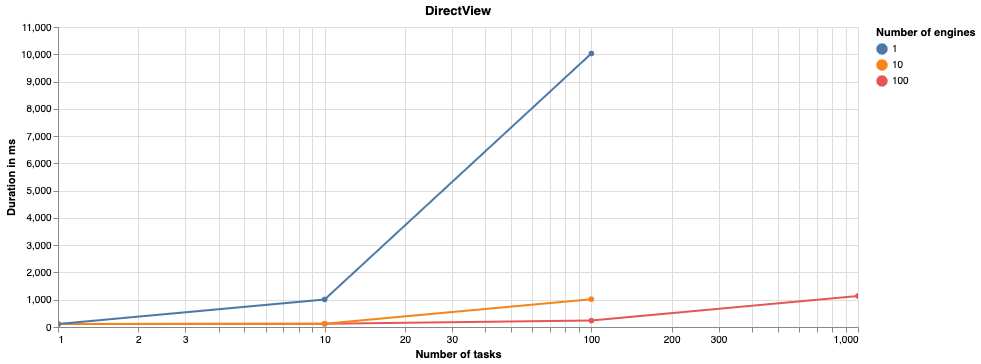

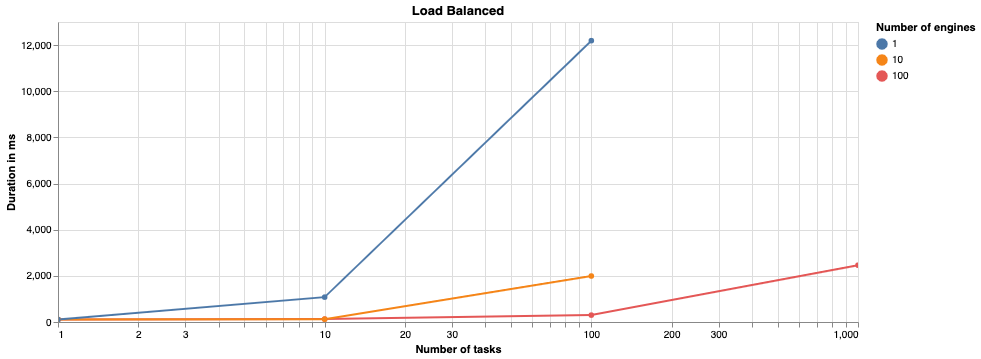

### With a delay of 1.0s. :

#### 16 cores:

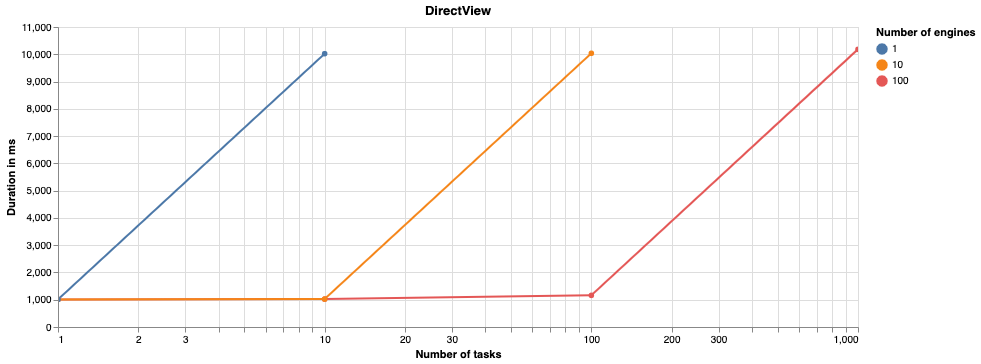

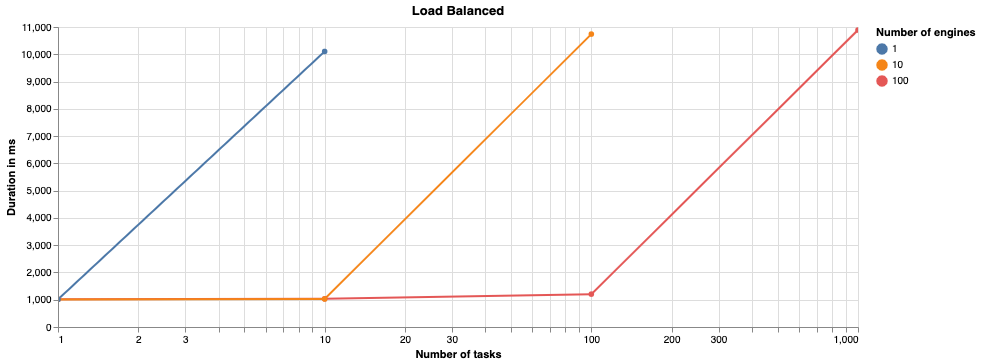

#### 64 cores:

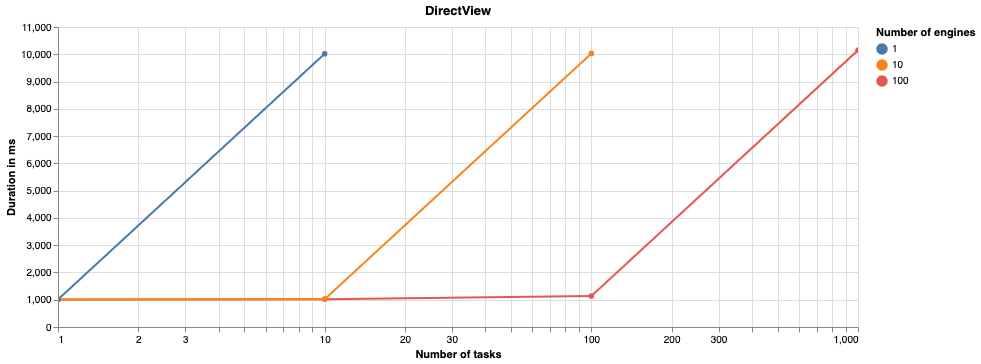

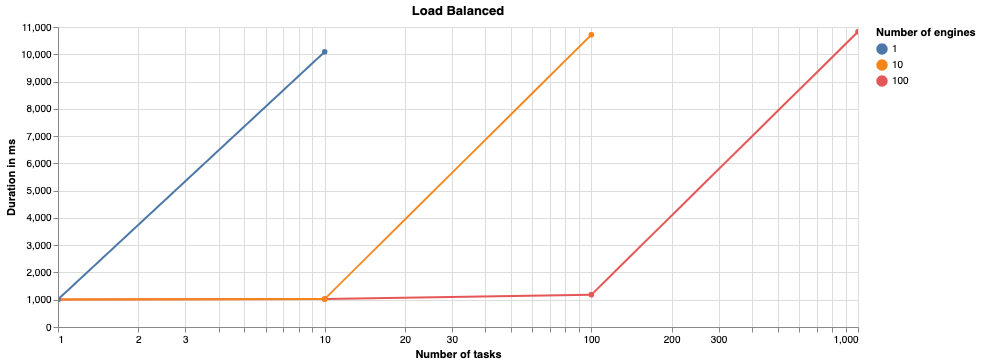

In [4]:
source = get_time_n_tasks_source(benchmark_results)
for delay, result_for_delay in source.items():
    display(Markdown(f'### With a delay of {ms_to_seconds(delay)}s. :'))
    
    for core_num, results in sorted(result_for_delay.items(), key=lambda key: key[0]):            
        display(Markdown(f'#### {core_num} cores:'))
        alt.Chart(
            pd.DataFrame(results['direct_view'])
        ).mark_line(point=True).encode(
            alt.X(
                'Number of tasks',
                scale=alt.Scale(type='log')
            ),
            y='Duration in ms',
            color='Number of engines:N',
            tooltip='Duration in ms'            
        ).properties(
            title=f'DirectView',
            width=800
        ).interactive().display(renderer='svg')
        
        alt.Chart(
            pd.DataFrame(results['load_balanced'])
        ).mark_line(point=True).encode(
            alt.X(
                'Number of tasks',
                scale=alt.Scale(type='log')
            ),
            y='Duration in ms',
            color='Number of engines:N',
            tooltip='Duration in ms'            
        ).properties(
            title=f'Load Balanced',
            width=800
        ).interactive().display(renderer='svg')

 
      

### With no delay and 100 engines:

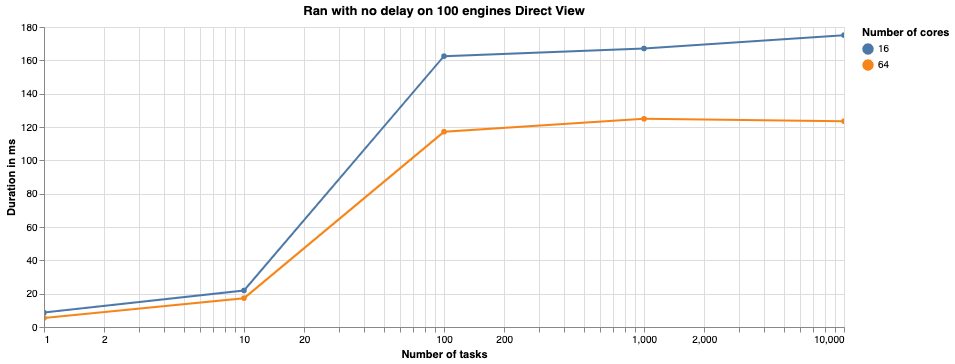

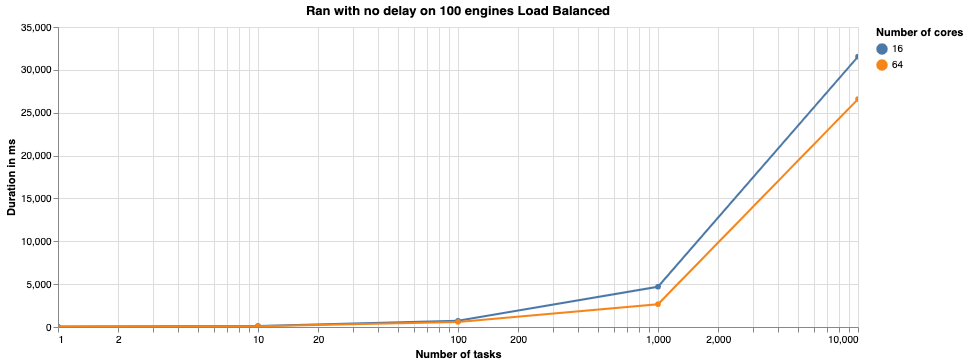

In [8]:
no_delay_source = get_no_delay_source(benchmark_results)
display(Markdown(f'### With no delay and 100 engines:'))
data = pd.DataFrame(no_delay_source[BenchmarkType.TIME_N_TASKS_NO_DELAY]['direct_view'])
alt.Chart(data).mark_line(point=True).encode(
    alt.X(
        'Number of tasks',
        scale=alt.Scale(type='log')
    ),
    color='Number of cores:N',
    y='Duration in ms',
    tooltip='Duration in ms',                         
).properties(title=f'Ran with no delay on 100 engines Direct View', width=800).interactive().display(renderer='svg')

data = pd.DataFrame(no_delay_source[BenchmarkType.TIME_N_TASKS_NO_DELAY]['load_balanced'])
alt.Chart(data).mark_line(point=True).encode(
    alt.X(
        'Number of tasks',
        scale=alt.Scale(type='log')
    ),
    color='Number of cores:N',
    y='Duration in ms',
    tooltip='Duration in ms',                         
).properties(title=f'Ran with no delay on 100 engines Load Balanced', width=800).interactive().display(renderer='svg')

### With no delay and non-blocking map on 100 engines:

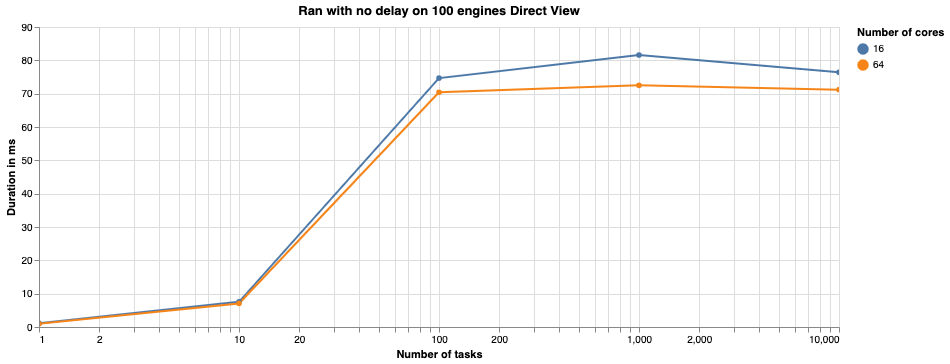

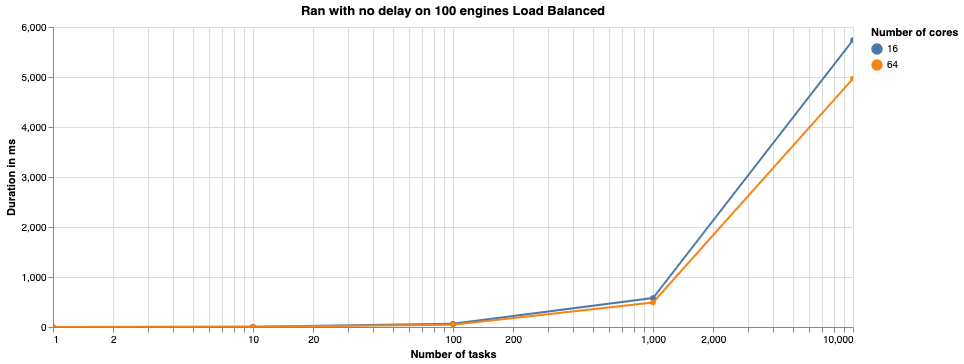

In [9]:
display(Markdown(f'### With no delay and non-blocking map on 100 engines:'))
data = pd.DataFrame(no_delay_source[BenchmarkType.TIME_N_TASKS_NO_DELAY_NON_BLOCKING]['direct_view'])
alt.Chart(data).mark_line(point=True).encode(
    alt.X(
        'Number of tasks',
        scale=alt.Scale(type='log')
    ),
    color='Number of cores:N',
    y='Duration in ms',
    tooltip='Duration in ms',                         
).properties(title=f'Ran with no delay on 100 engines Direct View', width=800).interactive().display(renderer='svg')

data = pd.DataFrame(no_delay_source[BenchmarkType.TIME_N_TASKS_NO_DELAY_NON_BLOCKING]['load_balanced'])
alt.Chart(data).mark_line(point=True).encode(
    alt.X(
        'Number of tasks',
        scale=alt.Scale(type='log')
    ),
    color='Number of cores:N',
    y='Duration in ms',
    tooltip='Duration in ms',                         
).properties(title=f'Ran with no delay on 100 engines Load Balanced', width=800).interactive().display(renderer='svg')

### time_broadcast ###
The second benchmark comes from benchmarking the runtime of sending
and array of n bytes to m engines. 

In [10]:
from benchmarks.throughput import NumpyArrayBroadcast
NumpyArrayBroadcast.time_broadcast??

Signature: NumpyArrayBroadcast.time_broadcast(self, engines, num_bytes)
Docstring: <no docstring>
Source:   
    def time_broadcast(self, engines, num_bytes):
        self.client[:engines]["x"] = np.array([0] * num_bytes, dtype=np.int8)
File:      ~/ipyparallel_master_project/benchmarks/throughput.py
Type:      function


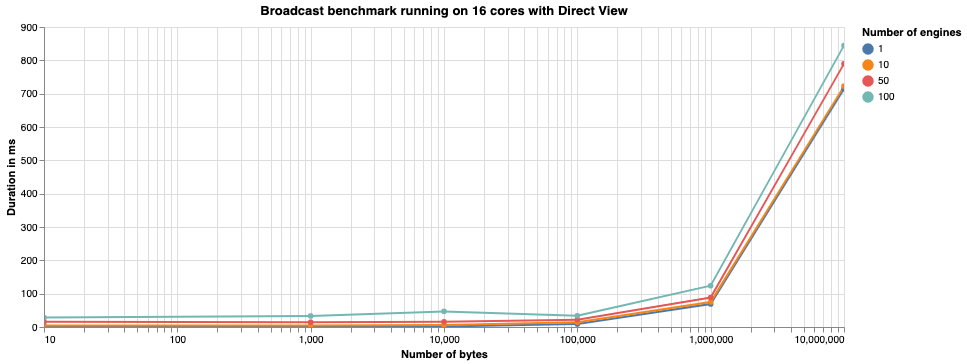

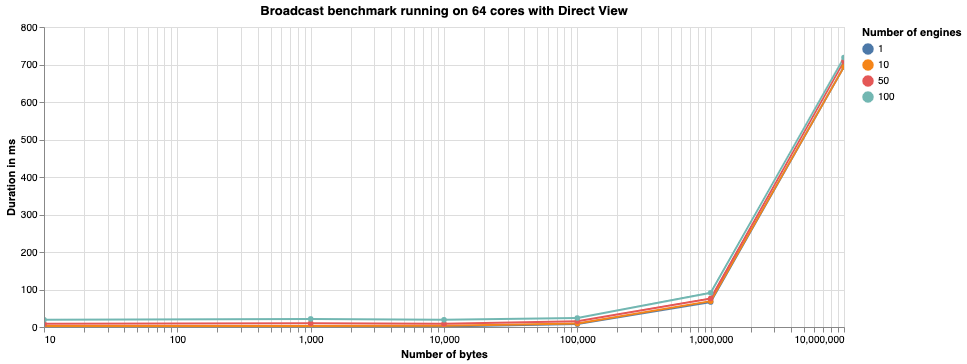

In [3]:
source = get_broad_cast_source(benchmark_results)
for core_num, results in sorted(source.items(), key=lambda key: key[0]):
    data = pd.DataFrame(results)
    alt.Chart(data).mark_line(point=True).encode(
        alt.X(
            'Number of bytes',
            scale=alt.Scale(type='log')
        ),
        y='Duration in ms',
        color='Number of engines:N',
        tooltip='Duration in ms',                         
    ).properties(title=f'Broadcast benchmark running on {core_num} cores with Direct View', width=800).interactive().display(renderer='svg')

### echo_many_arguments:

In [4]:
??echo_many_arguments

Signature: echo_many_arguments(view, number_of_arguments, n)
Docstring: <no docstring>
Source:   
def echo_many_arguments(view, number_of_arguments, n):
    view.map(
        lambda *x: x,
        [
            tuple(np.empty(1, dtype=np.int8) for n in range(number_of_arguments))
            for x in range(n)
        ],
        block=False,
    )
File:      ~/ipyparallel_master_project/benchmarks/overhead_latency.py
Type:      function


### With non-blocking map on 16 engines:

#### direct_view cores:

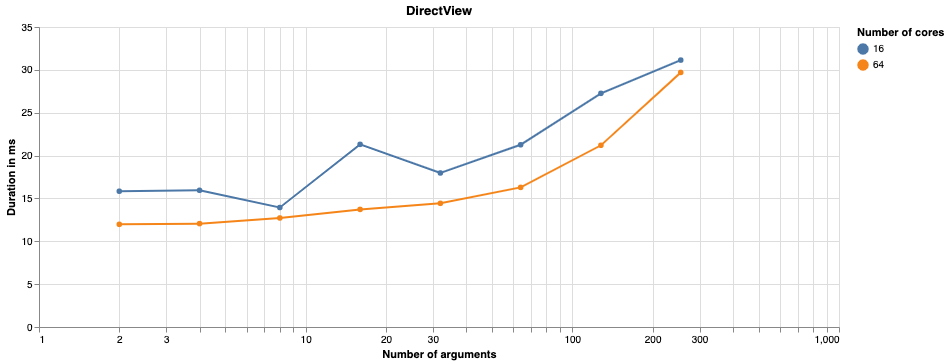

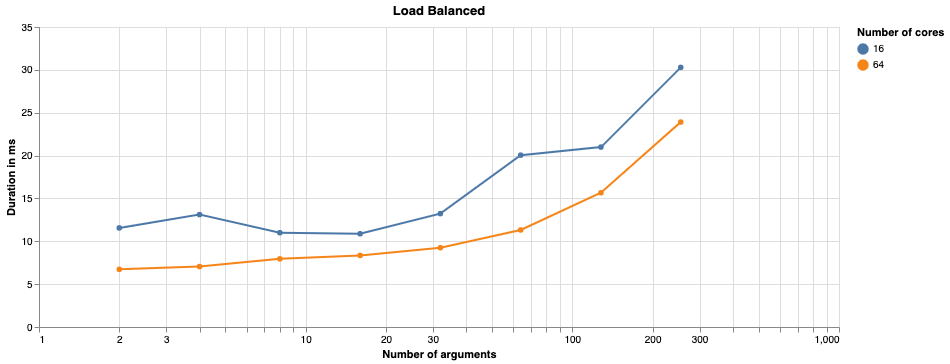

In [6]:
source = get_echo_many_arguments_source(benchmark_results)
display(Markdown(f'### With non-blocking map on {source["number_of_engines"]} engines:'))
display(Markdown(f'#### {core_num} cores:'))
alt.Chart(
    pd.DataFrame(source['direct_view'])
).mark_line(point=True).encode(
    alt.X(
        'Number of arguments',
        scale=alt.Scale(type='log')
    ),
    y='Duration in ms',
    color='Number of cores:N',
    tooltip='Duration in ms'            
).properties(
    title=f'DirectView',
    width=800
).interactive().display(renderer='svg')        

alt.Chart(
    pd.DataFrame(source['load_balanced'])
).mark_line(point=True).encode(
    alt.X(
        'Number of arguments',
        scale=alt.Scale(type='log')
    ),
        y='Duration in ms',
        color='Number of cores:N',
        tooltip='Duration in ms'            
    ).properties(
        title=f'Load Balanced',
        width=800
    ).interactive().display(renderer='svg')